In [1]:
from datasets import get_dataset

from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np

from synthcity.plugins.models.time_to_event.loader import get_model_template
from synthcity.plugins import Plugins
from synthcity.utils.serialization import dataframe_hash, load_from_file, save_to_file
from lifelines import KaplanMeierFitter
import string
from synthcity.plugins.models.survival_analysis.metrics import nonparametric_distance

out_dir = Path("workspace")
fontsize = 14
plt.style.use("seaborn-whitegrid")
#plt.style.use("ggplot")

 
def generate_score(metric: np.ndarray) -> tuple:
    percentile_val = 1.96
    score = (np.mean(metric), percentile_val * np.std(metric) / np.sqrt(len(metric)))
 
    return round(score[0], 4), round(score[1], 4)
 
 
def generate_score_str(metric: np.ndarray) -> str:
    mean, std = generate_score(metric)
    return str(mean) + " +/- " + str(std)

    
def map_models(model):
    return {
        "survival_gan": "SurvivalGAN", 
        "adsgan": "AdsGAN", 
        "ctgan": "CTGAN", 
        "tvae": "TVAE", 
        "privbayes": "PrivBayes", 
        "nflow": "nFlows"
    }[model]

def plot_km(
    ax,
    title,
    T: pd.Series,
    E: pd.Series,
    syn_T: pd.Series,
    syn_E: pd.Series,
    ci_show: bool = True,
    ci_alpha: float = 0.2,
    show_censors: bool = False,
    syn_label: str = None,
    xaxis_label: str = None,
    yaxis_label: str = None,
    show_title: bool = True,
) -> None:
    gt_kmf = KaplanMeierFitter()
    gt_kmf.fit(T, E, label="Real data")  # t = Timepoints, Rx: 0=censored, 1=event
    ax = gt_kmf.plot(ax = ax, ci_show=ci_show, ci_alpha=ci_alpha, show_censors=show_censors)

    if syn_label is None:
        syn_label = "Synthetic data"
        
    syn_kmf = KaplanMeierFitter()
    syn_kmf.fit(
        syn_T, syn_E, label=syn_label
    )  # t = Timepoints, Rx: 0=censored, 1=event
    ax = syn_kmf.plot(
        ax=ax, ci_show=ci_show, ci_alpha=ci_alpha, show_censors=show_censors
    )
    ax.axvline(T[E == 1].max(), color="r", linestyle="--")  # vertical
    if show_title:
        ax.set_xlabel(title, horizontalalignment="center")
    else:
        ax.set_xlabel("Days", horizontalalignment="center")
    
    if yaxis_label is None:
        yaxis_label = "Temporal fidelity(Kaplan-Meier)"
    ax.set_ylabel(yaxis_label, fontsize = 20)

 
def plot_grouped_km(
    dataset: str,
    models: list,
    individual: bool = False,
    ci_show: bool = True,
    ci_alpha: float = 0.2,
    save: bool = False,
    **kwargs,
):
    df, duration_col, event_col, time_horizons = get_dataset(dataset)
    df_hash = dataframe_hash(df)
    
        
    results = {}
    for repeat_id in range(5):

        model_bkp = (
            out_dir
            / f"{df_hash}_survival_gan_{repeat_id}.bkp"
        )
        if not model_bkp.exists():
            continue

        fig, axs = plt.subplots(1, len(models), figsize = (5 * len(models), 4))

        for idx, model in enumerate(models):
            if model not in results:
                results[model] = {
                    "opt": [],
                    "abs_opt": [],
                    "sight": [],
                }
            model_bkp = (
                out_dir
                / f"{df_hash}_{model}_{repeat_id}.bkp"
            )
            if model_bkp.exists():
                syn_df = load_from_file(model_bkp)
            else:
                continue


            auc_opt, auc_abs_opt, sightedness = nonparametric_distance((df[duration_col], df[event_col]),
                                                        (syn_df[duration_col], syn_df[event_col]),
                                                       )
            results[model]["opt"].append(auc_opt)    
            results[model]["abs_opt"].append(auc_abs_opt)   
            results[model]["sight"].append(sightedness)
            plot_km(axs[idx], 
                    map_models(model), 
                    df[duration_col], 
                    df[event_col], 
                    syn_df[duration_col], 
                    syn_df[event_col],
                    syn_label = f"Synthetic model: {map_models(model)}",
                    show_title = True,
                    yaxis_label = f"Seed {repeat_id}"
                   )

        if save:
            plt.savefig(f"diagrams/grouped_kmplot_synth_gen_{dataset}_{model}_{repeat_id}.pdf")
        plt.show()
        
    cols = ["model", "opt", "abs_opt", "sight"]
    out = pd.DataFrame([], columns = cols)
    for model in results:
        local = [model]
        for metric in results[model]:
            local.append(generate_score_str(results[model][metric]))
        out = out.append(pd.DataFrame([local], columns = cols))
    return out



In [2]:
baseline_models = ["survival_gan", "adsgan", "ctgan", "tvae", "privbayes", "nflow"]

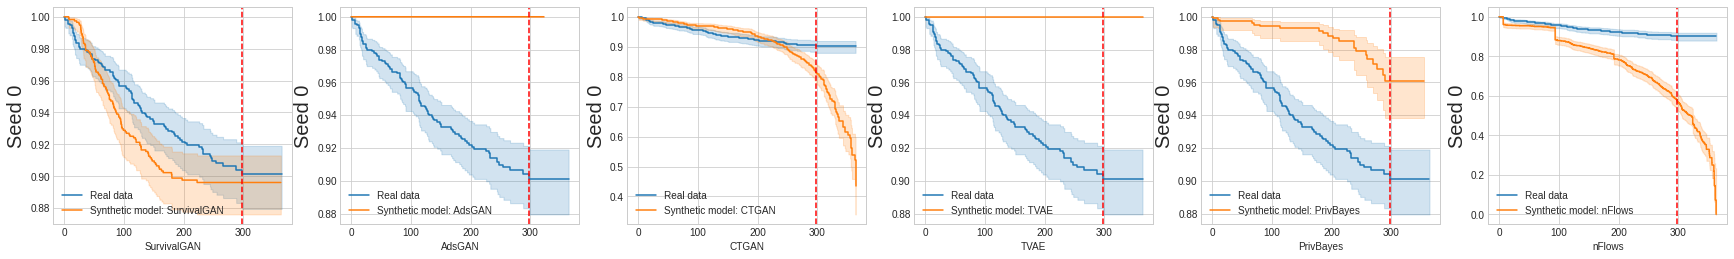

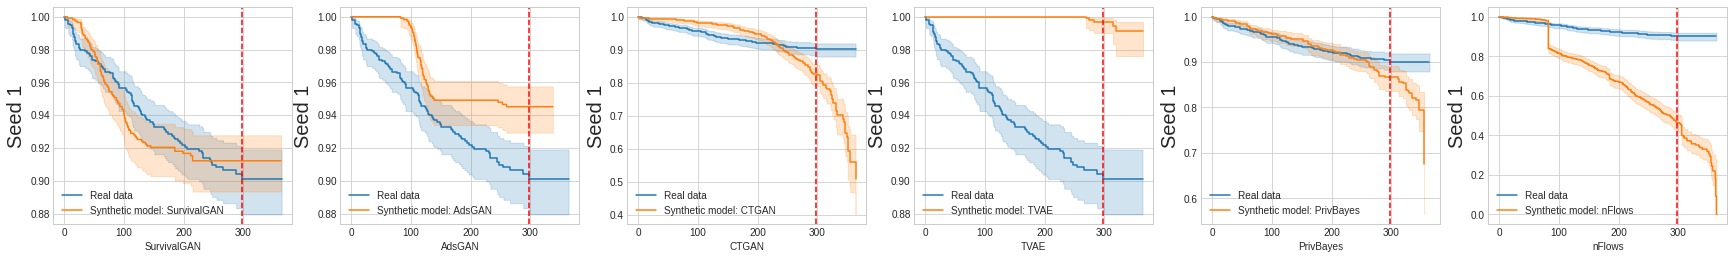

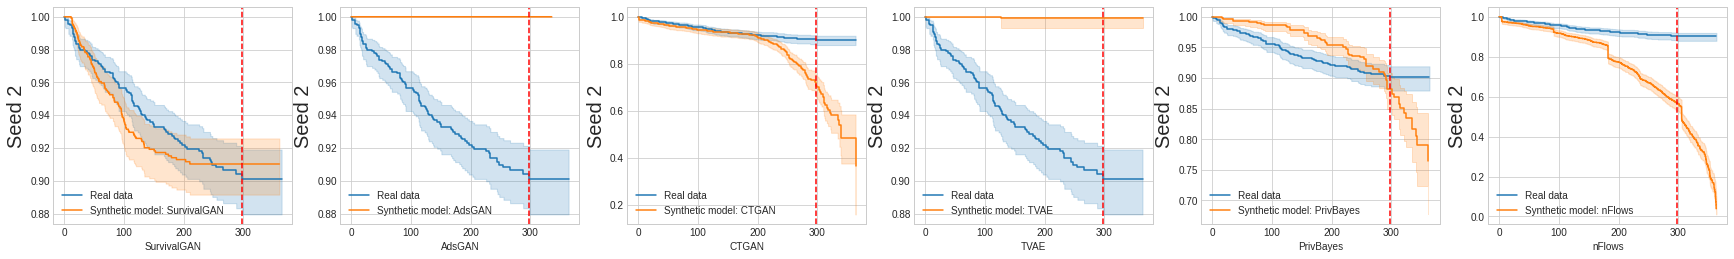

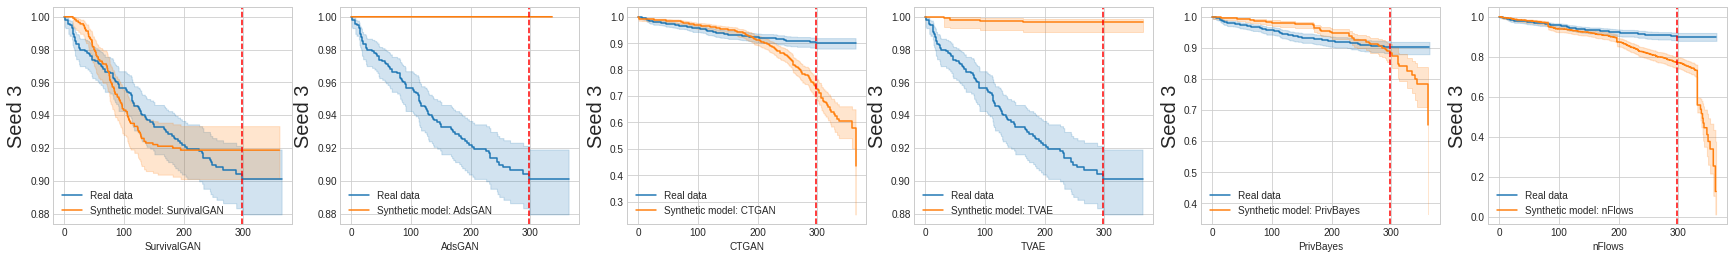

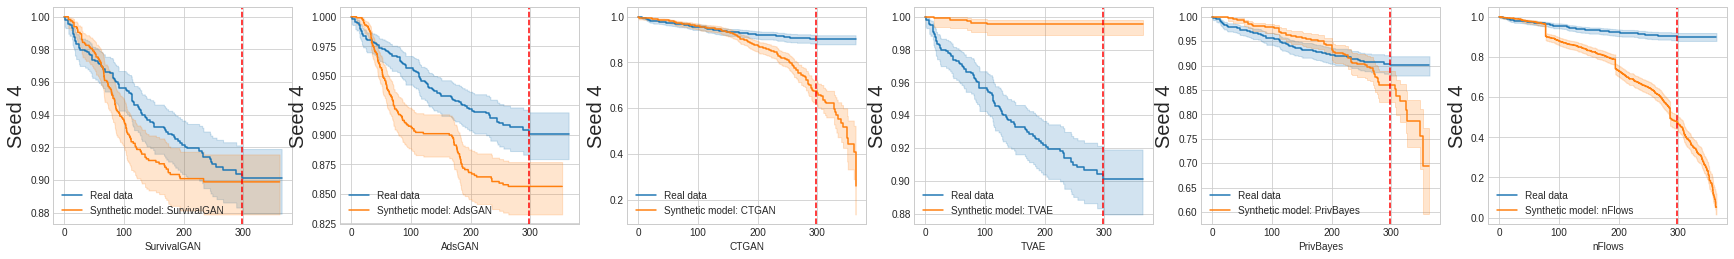

,model,opt,abs_opt,sight
0,survival_gan,-0.0055 +/- 0.0053,0.0112 +/- 0.0019,0.0072 +/- 0.0029
0,adsgan,0.0377 +/- 0.0357,0.0535 +/- 0.0136,0.0737 +/- 0.0234
0,ctgan,-0.0605 +/- 0.0233,0.0734 +/- 0.0148,0.0 +/- 0.0
0,tvae,0.0641 +/- 0.0012,0.0641 +/- 0.0012,0.0 +/- 0.0
0,privbayes,0.0063 +/- 0.0205,0.035 +/- 0.0074,0.0126 +/- 0.0098
0,nflow,-0.183 +/- 0.0473,0.185 +/- 0.048,0.0007 +/- 0.0006


In [3]:
plot_grouped_km(
            "aids", models=baseline_models, save = True
        )

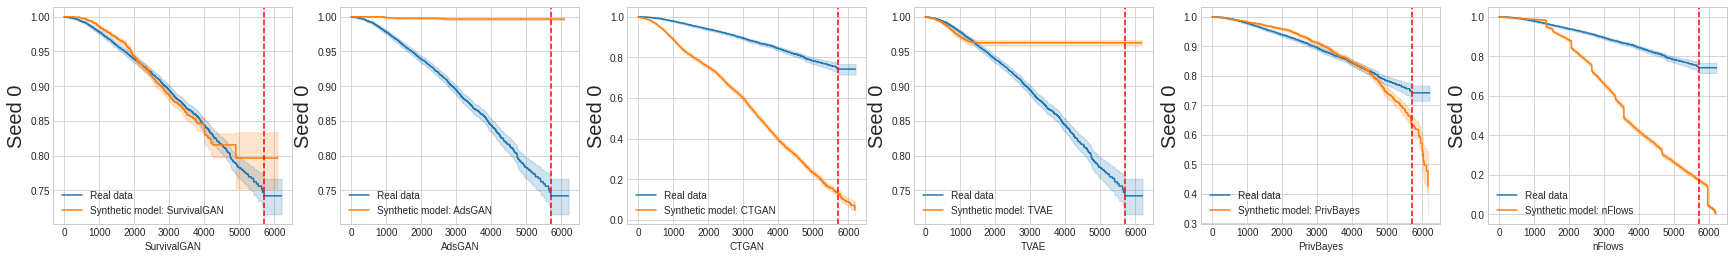

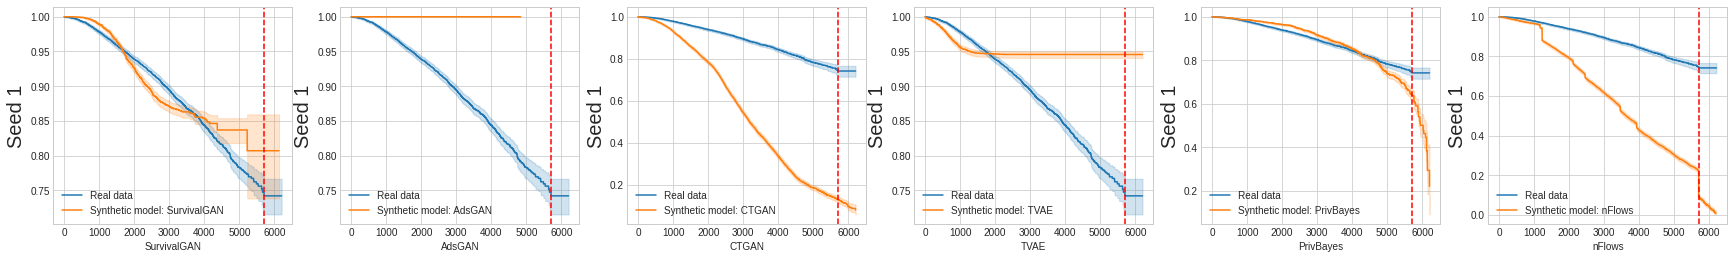

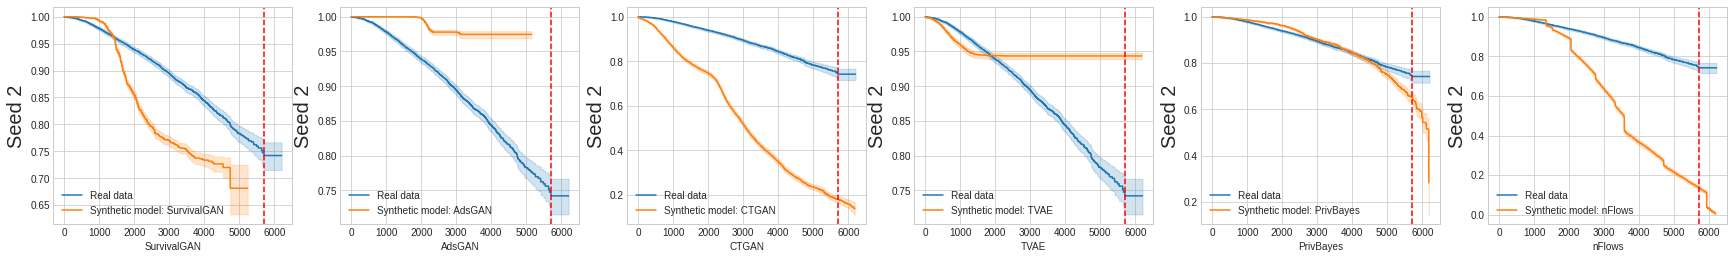

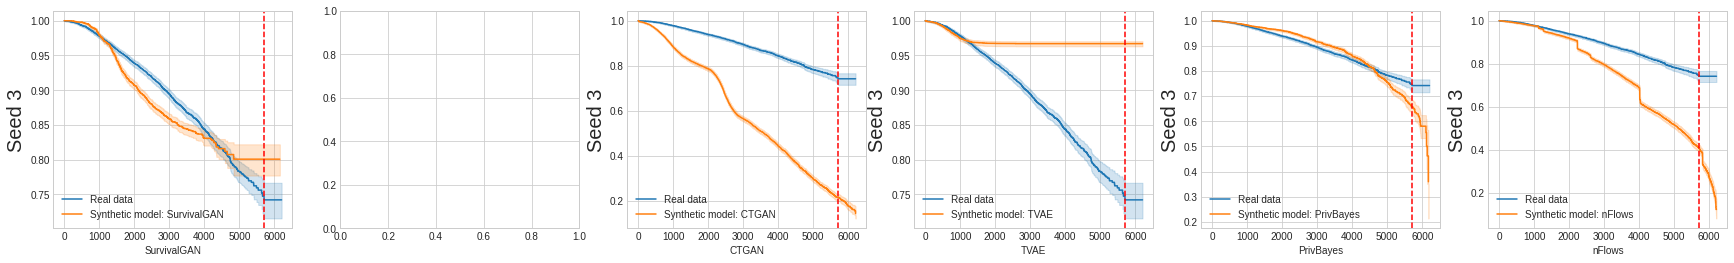

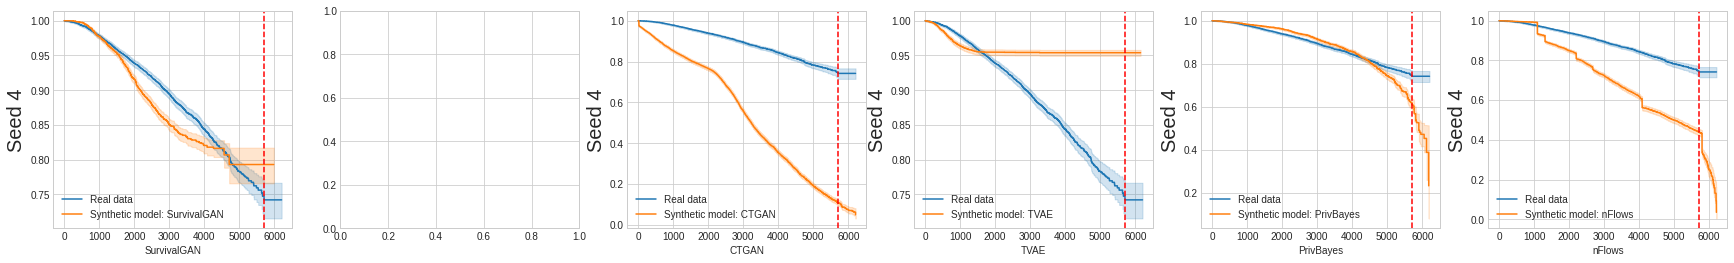

,model,opt,abs_opt,sight
0,survival_gan,-0.0123 +/- 0.0268,0.0312 +/- 0.0196,0.0462 +/- 0.0489
0,adsgan,0.1132 +/- 0.008,0.1132 +/- 0.008,0.1366 +/- 0.0972
0,ctgan,-0.3335 +/- 0.0168,0.3335 +/- 0.0168,0.0013 +/- 0.0014
0,tvae,0.0794 +/- 0.0071,0.0834 +/- 0.0049,0.0031 +/- 0.0028
0,privbayes,-0.0168 +/- 0.0034,0.0343 +/- 0.0038,0.0038 +/- 0.002
0,nflow,-0.2363 +/- 0.0552,0.2375 +/- 0.0555,0.002 +/- 0.0014


In [4]:
plot_grouped_km(
            "cutract", models=baseline_models, save = True
        )

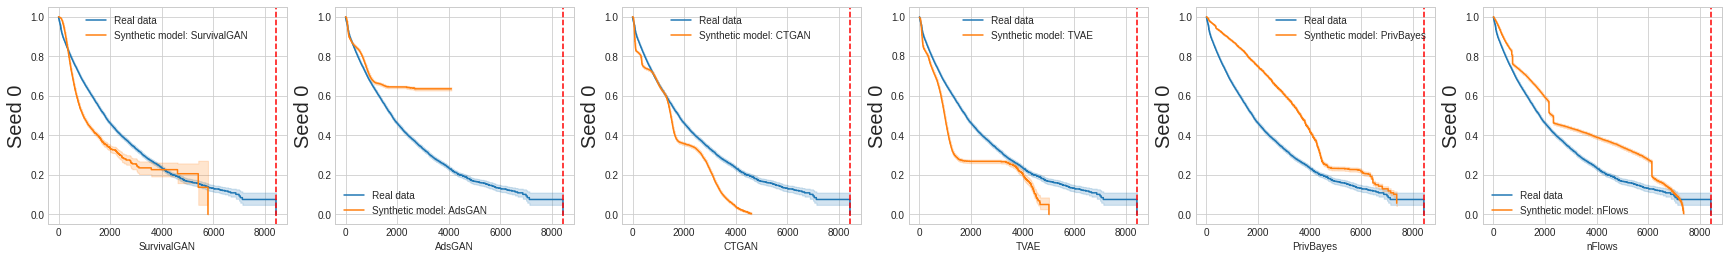

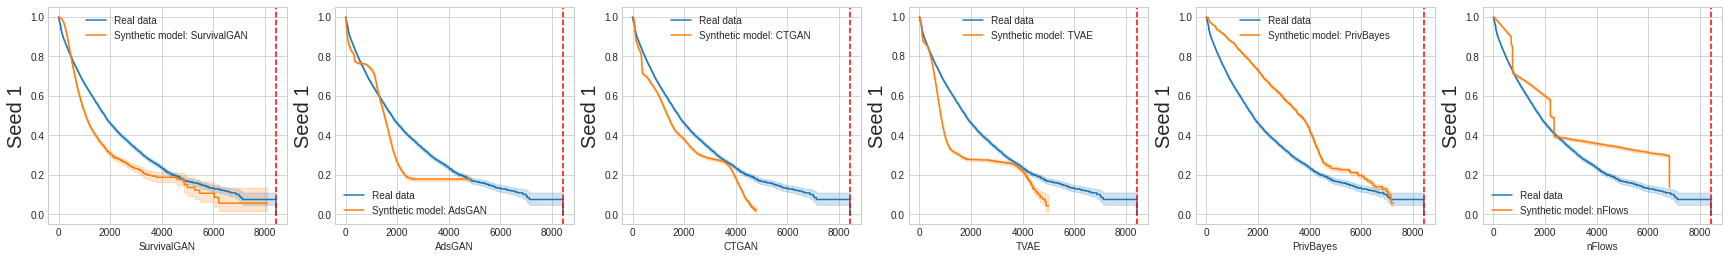

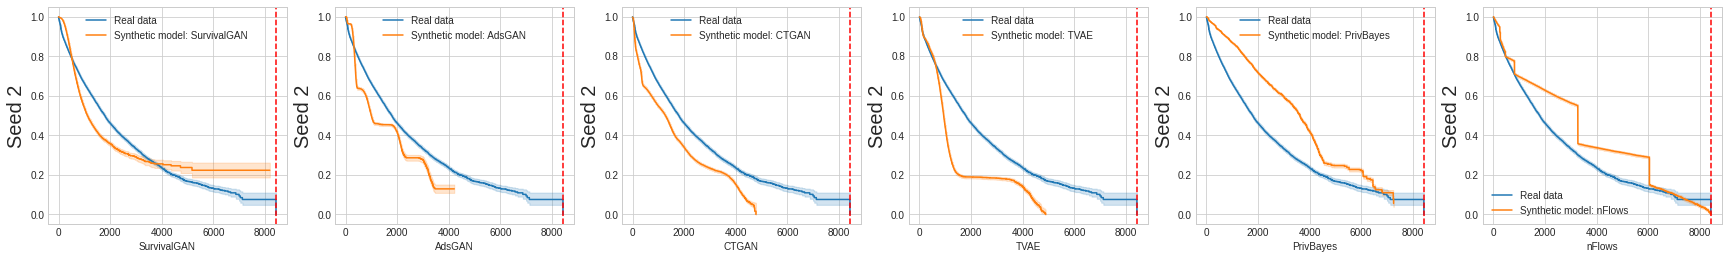

,model,opt,abs_opt,sight
0,survival_gan,-0.0355 +/- 0.0483,0.0787 +/- 0.0092,0.1274 +/- 0.1486
0,adsgan,0.0959 +/- 0.2045,0.1674 +/- 0.1472,0.4788 +/- 0.0449
0,ctgan,-0.0991 +/- 0.0156,0.0993 +/- 0.0155,0.4382 +/- 0.0117
0,tvae,-0.1148 +/- 0.0221,0.1154 +/- 0.0228,0.4102 +/- 0.0077
0,privbayes,0.1292 +/- 0.0051,0.1344 +/- 0.0048,0.1351 +/- 0.0081
0,nflow,0.0909 +/- 0.0106,0.0995 +/- 0.0054,0.1055 +/- 0.0893


In [5]:
plot_grouped_km(
            "maggic", models=baseline_models, save = True
        )

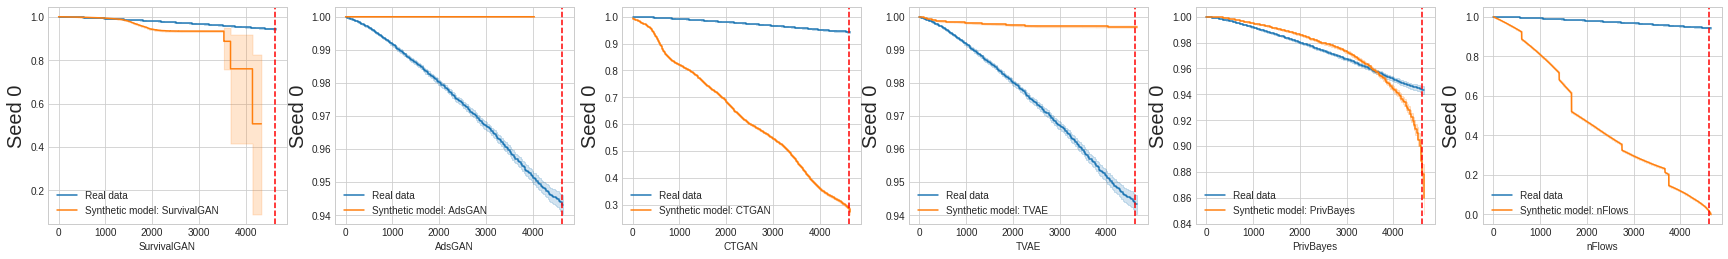

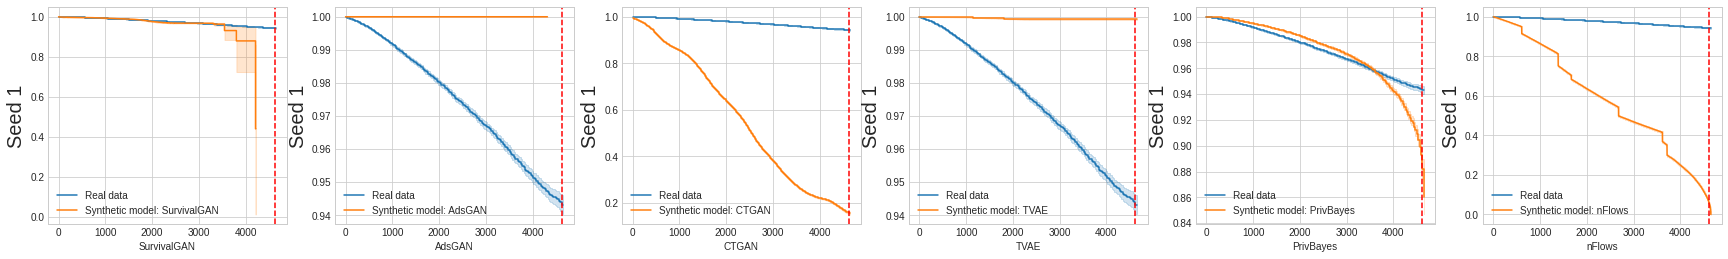

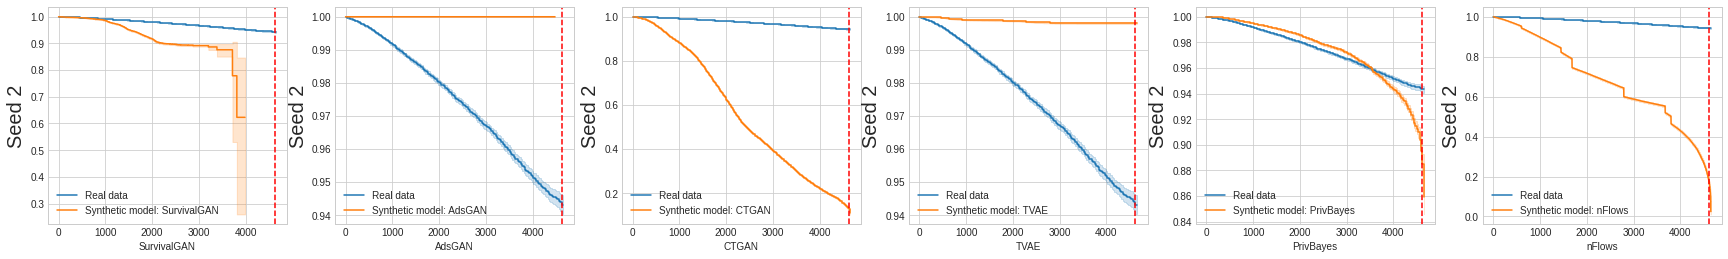

,model,opt,abs_opt,sight
0,survival_gan,-0.079 +/- 0.0199,0.0797 +/- 0.0193,0.1009 +/- 0.0353
0,adsgan,0.0255 +/- 0.0,0.0255 +/- 0.0,0.08 +/- 0.0445
0,ctgan,-0.3861 +/- 0.0377,0.3861 +/- 0.0377,0.0 +/- 0.0
0,tvae,0.0241 +/- 0.0008,0.0241 +/- 0.0008,0.0 +/- 0.0
0,privbayes,-0.0009 +/- 0.0004,0.0066 +/- 0.0002,0.0 +/- 0.0
0,nflow,-0.3917 +/- 0.0953,0.3917 +/- 0.0953,0.0001 +/- 0.0


In [6]:
plot_grouped_km(
            "seer", models=baseline_models, save = True
        )